## **A simple quantum circuit for binary classification for the Iris dataset**

**File name: iris.ipynb**

**Author: Du Huynh**

*Date created: April/May 2023*<br>
*Last modified: February 29th 2024*

This small Jupyter Notebook file shows that, with appropriate normalisation of the data, we need only a simple circuit with **2 qubits** and **2 variational parameters** to classify the **setosa** and **versicolor** classes for the **iris** dataset. These two classes are known to be linearly separable, so two variational parameters are sufficient.

**As an exercise, try changing the random seeds in the code cell below to see slightly different results. Note: the random seeds for `random`, `torch`, and `numpy` do not need to be the same.**
    
Required libraries to run the code: **PyTorch**, **Pennylane**, **pandas**, **numpy**, and **matplotlib**.

In [1]:
import torch
import pennylane as qml
import pandas as pd

import numpy

import matplotlib
from matplotlib import pyplot as plt

import random
random.seed(12345)

torch.manual_seed(12345)
numpy.random.seed(12345)

### **Helper functions**

In [2]:
def save_fig(filename, tight_layout=True, fig_extension="pdf", resolution=300):
    '''
    This function saves the current figure to the given file in pdf format.
    The saved image can be included in a LaTeX document, e.g., a research paper.
    '''
    if tight_layout:
        plt.tight_layout()
    plt.savefig(filename, format=fig_extension, dpi=resolution)
    
    
def plot_learning_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    fig.tight_layout(pad=3.0)
    iterations = torch.arange(len(train_loss)) + 1
    for ax,train,test,ylab,ylim in zip(axes,[train_loss,train_acc],[val_loss,val_acc],
                              ['Loss', 'Accuracy'], [1,1]):
        ax.plot(iterations, train, 'r-')
        ax.plot(iterations, test, 'b-')
        ax.legend(['Training set', 'Validation set'])
        ax.set_xlabel('Iterations')
        ax.set_ylabel(ylab)
        ax.grid('on')
        ax.set_ylim(0, ylim+0.1)
        

def normalise(x, minval, maxval):
    '''
    This function returns the linearly normalised data stored in
    argument x to the range [minval,maxval]. Argument x can be
    a numpy nd-array or a torch tensor.
    '''
    # current min and max values of the data in x
    m, M = x.min(), x.max()
    # desired (new) min and max values is minval and maxval
    return (x-m) / (M-m) * (maxval-minval) + minval


def cross_entropy_loss(probs, labels, epsilon=1e-10):
    '''
    This function returns the cross entropy loss (as a scalar) for the predicted
    probabilities, probs.
    
    Input arguments:
    - probs: should be a m-by-2 torch tensor where each row corresponds
        to the output predictions for the two classes for each data instance
    - labels: also m-by-2, should be the one-hot-encoding of the ground
        truth classes for the m data instances.
    epsilon is a small value to avoid the possible calculation of log(0).
    '''
    return -((probs+epsilon).log() * labels).sum() / probs.shape[0]
    

def cost(theta, x, labels):
    '''
    This function returns the cost (i.e., the cross entropy loss)
    for the variational parameters stored in `theta`, input data `x`,
    and the ground truth class IDs stored in one-hot encoding format.
    '''
    predprobs = circuit_probs(theta, x)
    return cross_entropy_loss(predprobs, labels), predprobs


def accuracy(probs, labels):
    '''
    This function returns the accuracy of the predictions.
    Input arguments:
    - probs: the predicted probabilities, as an m-by-2 tensor.
    - labels: the ground truth class IDs stored in one-hot encoding
              format.
    '''
    return (torch.argmax(probs, axis=1) == 
            torch.argmax(labels, axis=1)).sum() / probs.shape[0]


def compute_prob_stat(probs, labels):
    '''
    This function computes and returns some statistics about the
    predicted probabilities given in the first argument, probs.
    It is useful for debugging / inspecting performance of model
    during the training process.
    '''
    bool = torch.argmax(probs, axis=1) == torch.argmax(labels, axis=1)
    # variable p below contains the probabilities of all the
    # correct predictions
    p = probs[bool].max(axis=1).values
    return p.min(), p.max(), p.mean()
    
    
def prepare_data(csvfile, minval, maxval):
    '''
    This function reads the iris data from the specified csv file,
    linearly normalises the data to the range [minval,maxval] and
    outputs the following:
    - x: a 2-by-100 torch tensor where each column stores one data
        instance. The features stored in x are "petal_length" and
        "petal_width".
    - y: the one-hot encoding of the ground truth class IDs. A 1 in
        column 0 denotes a "setosa" instance; a 1 in column 1 denotes
        a "versicolor" instance.
    - column_names - column names (["petal_length", "petal_width"]) of the data.
    - class_ids - [0, 1]
    - features - the original, un-normalised, version of the data (for
            later visualisation).
    '''
    # Read in the data.
    df = pd.read_csv(csvfile)

    # Take the first 100 instances, i.e., setosa and versicolor.
    # Relabel them as classes 0 and 1. We will use petal_length
    # and petal_width only as the two features (they are in
    # columns 2 and 3). Also, convert the data to numpy arrays.
    class_names = numpy.unique(df.species)[:2]
    class_ids = numpy.array([0, 1])

    # normalise features so that the range is [minval,maxval]
    tmp = df.to_numpy()
    features = tmp[:100, 2:4].astype(numpy.float64)
    x = normalise(features, minval, maxval)
    
    column_names = df.columns[2:4]

    label = tmp[:100, -1]
    y = numpy.zeros(label.shape).astype(int)
    for i in range(2):
        y[label == class_names[i]] = class_ids[i]

    # finally, convert to torch tensor
    # *** transpose the data so that each column corresponds to one data instance ***
    x = torch.transpose(torch.from_numpy(x), 0, -1)
    y = torch.nn.functional.one_hot(torch.from_numpy(y), num_classes=2)
    
    return x, y, column_names, class_names, class_ids, features
    

### **Data preparation**

In the code below, the features (`petal_length` and `petal_width`) are normalised to the range $[0, \pi]$. 80% of the 100 data instances are randomly sampled and used for training and the remaining 20% are for validation.
    
**Note that each column of the data feature matrix `x` in the code below stores an instance. This is different from classical ML where we usually have each row in the data feature matrix corresponds to one instance. This helps to speed up the computation significantly -- the entire batch (or minibatch, if minibatches are used) of data (rather than one data item at a time) is passed to the circuit (function `circuit_probs` later on).**

In [3]:
x, y, column_names, class_names, class_ids, features = \
    prepare_data('data/iris_raw.csv', 0.0, numpy.pi)

dataset_size = x.shape[1]
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

print('Dataset size =', dataset_size)
print('Training set size =', train_size)
print('Validation set size =', val_size)

randindex = torch.randperm(dataset_size)
train_index = randindex[:train_size]
val_index = randindex[train_size:]

features_train = features[train_index,:]
features_val = features[val_index,:]

x_train = x[:,train_index]
y_train = y[train_index,:]
x_val = x[:,val_index]
y_val = y[val_index,:]

Dataset size = 100
Training set size = 80
Validation set size = 20


### **Quantum circuit**

The circuit designed for this simple Iris dataset has two qubits. 
* For the 0th qubit, a rotation about the $X$-axis is applied. The rotation angle is the sum of `x[0]` (*Petal length*) and an unknown variational parameter `theta[0]` ($\theta_0$). We can think of this rotation as two separate rotations in sequence: `RX(x[0])` then `RX(theta[0])`. As the two rotations are about the same axis, the two rotation angles can be added together. 
* For the 1st qubit, a rotation about the $Y$-axis is applied. Here, the rotation angle is the sum of `x[1]` (*Petal width*) and `theta[1]` ($\theta_1$).
* After these rotations, the two qubits are entangled together through a **controlled NOT** gate, where the the 0th qubit is the **control qubit** and the 1st qubit is the **target qubit**.
* Finally, a measurement is taken at the 1st qubit. In the code below, we specify that we want the probabilities for $|0\rangle$ and $1\rangle$ to be returned. These two probabilities add up to 1.

So the circuit only has two variational parameters that need to be trained. We can put them together as a 2D vector: $\boldsymbol{\theta} = (\theta_0, \theta_1)$. By storing the data `x` in the column format (i.e., one column corresponds to one training instance), then `x[0]` refers the *Petal length* of all the instances and `x[1]` refers to the *Petal width* of all instances. This makes it possible to do bulk computation on all the instances in one go, rather than one instance at a time. See the line `torch.transpose` in the function `prepare_data` above.

In [4]:
num_qubits = 2

dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface='torch')
def circuit_probs(theta, x):
    qml.BasisState(z, wires=range(num_qubits))
    
    qml.RX(theta[0]+x[0], wires=0)
    qml.RY(theta[1]+x[1], wires=1)
    qml.CNOT(wires=[0,1])
    
    return qml.probs([1])

### **Training the circuit**

In the code below, we use the Adam optimiser with the learning rate set to $0.05$.

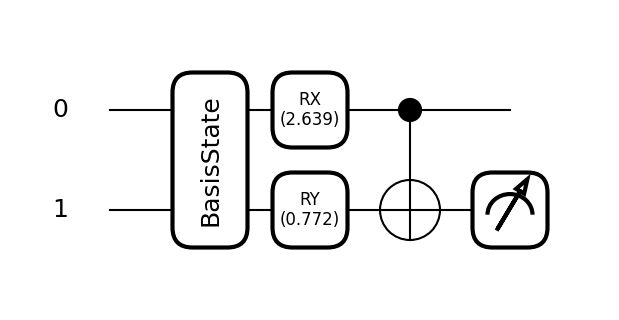

In [5]:
z = numpy.zeros(2,)  # initial state of the circuit

theta0 = 0.1 * torch.randn(2)

qml.draw_mpl(circuit_probs, fontsize=18, decimals=3)(theta0, x_train[:,0]);

# The numbers 0 and 1 on the far left of the diagram denote the qubit indices.

We can omit the last `print` statement in the `for` loop in the code below as well, since it is more useful to inspect the learning curves graphically.

**Note that the variational parameter $\boldsymbol{\theta}$ varies quite a fair bit over the training epochs, even though the training and validation accuracies are already very good at epoch 0. This is because the initial training loss is still quite high. The cross entropy loss is what we try to minimize here (we cannot train the circuit to improve accuracy directly, but we expect that lowering the loss will result in increase in accuracy).** 

As an example, we train for 20 epochs only, which is more than enough for this simple dataset.

The final optimal values for the two components of $\boldsymbol{\theta}$ can be found in the last training epoch.

In [6]:
print('initial theta = ', theta0)
theta = torch.tensor([theta0[0], theta0[1]], requires_grad=True)

# use the Adam optimizer, with learning rate set to 0.05. Can also try other optimizers.
opt = torch.optim.Adam([theta], lr = 0.05) 

rad2deg = 180.0 / numpy.pi

maxep = 20

# for plotting later on
train_losses, val_losses, train_accs, val_accs = \
    torch.zeros(4, maxep, requires_grad=False)

# train the variational classifier
print('The second last column shows the min, max, and mean probabilities')
print('of the correct predictions on the training set.\n')

print('{:5s} | {:7s} | {:20s} | {:17s} | {:17s} '
      ''.format('Epoch', 'Loss', 'Train/Val accuracies', 'min/max/mean prob',
               'theta (degrees)'))

for ep in range(maxep):
    # Update theta by one optimizer step
    opt.zero_grad()
    train_loss, train_predprob = cost(theta, x_train, y_train)
    val_loss, val_predprob = cost(theta, x_val, y_val)
    
    train_acc = accuracy(train_predprob, y_train)
    val_acc = accuracy(val_predprob, y_val)
    
    minProb, maxProb, meanProb = compute_prob_stat(train_predprob, y_train)
    train_loss.backward()   # compute the derivative of train_loss with respect to theta
    if ep < maxep-1:
        # update the parameter theta only if we are not yet at the last epoch.
        opt.step()              

    print("{:5d} | {:7.5f} | {:9.5f} {:9.5f}  | {:5.3f} {:5.3f} {:5.3f} | {:7.2f},{:7.2f}"
           "".format(ep, train_loss, train_acc, val_acc, minProb, maxProb, meanProb,
                    theta[0]*rad2deg, theta[1]*rad2deg))

    # save the training/validation losses and accuracies for plotting
    train_losses[ep] = train_loss.clone().detach()
    val_losses[ep] = val_loss.clone().detach()
    train_accs[ep] = train_acc
    val_accs[ep] = val_acc

print()
minvProb, maxvProb, meanvProb = compute_prob_stat(val_predprob, y_val)
print(f'min/max/mean validation probabilities = {minvProb:5.3f} {maxvProb:5.3f} {meanvProb:5.3f}')

initial theta =  tensor([-0.0625,  0.0809])
The second last column shows the min, max, and mean probabilities
of the correct predictions on the training set.

Epoch | Loss    | Train/Val accuracies | min/max/mean prob | theta (degrees)   
    0 | 0.22526 |   1.00000   1.00000  | 0.647 0.934 0.801 |   -6.45,   1.77
    1 | 0.21120 |   1.00000   1.00000  | 0.633 0.948 0.812 |   -9.21,  -1.08
    2 | 0.19998 |   1.00000   1.00000  | 0.618 0.959 0.822 |  -11.70,  -3.90
    3 | 0.19151 |   1.00000   1.00000  | 0.603 0.968 0.830 |  -13.65,  -6.69
    4 | 0.18527 |   1.00000   1.00000  | 0.590 0.973 0.836 |  -14.81,  -9.41
    5 | 0.18043 |   1.00000   0.95000  | 0.583 0.974 0.840 |  -15.14, -12.06
    6 | 0.17630 |   1.00000   0.95000  | 0.582 0.972 0.843 |  -14.80, -14.61
    7 | 0.17263 |   1.00000   0.95000  | 0.586 0.968 0.846 |  -13.98, -17.06
    8 | 0.16949 |   1.00000   1.00000  | 0.594 0.961 0.848 |  -12.82, -19.37
    9 | 0.16700 |   1.00000   1.00000  | 0.604 0.953 0.850 |  -11.46

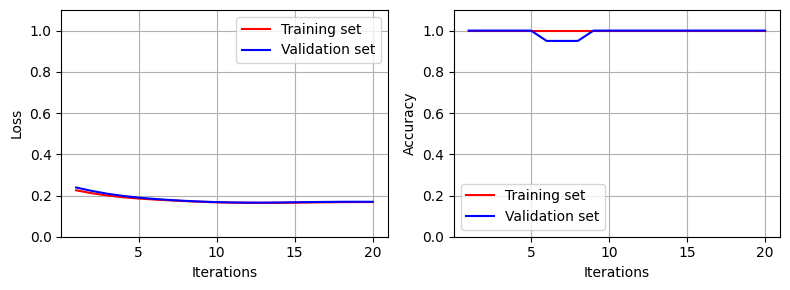

In [7]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

# save figure
save_fig("iris_learning_curves.pdf")

### **Visualisation of the predicted outputs**

In [8]:
def show_predictions(feat, y_true, y_pred, class_names, column_names,
                    title_str):
    _, axes = plt.subplots(1, 2, figsize=(8,3))
    for ax,y,title in zip(axes,[y_true,y_pred],['Ground truth','Predictions']):
        for classk,cmarker in zip(range(2),['r*','bx']):
            if ax == axes[0]:
                ind = y[:,classk] == 1
            else:
                ind = y[:,classk] >= y[:,(classk+1)%2]
            ax.plot(feat[ind,0], feat[ind,1], cmarker, label=class_names[classk])
        ax.grid('on')
        ax.set_box_aspect(0.65)
        ax.legend(loc='best')
        ax.set_xlabel(column_names[0])
        if ax == axes[0]:
            ax.set_ylabel(column_names[1])
        ax.set_title(title)
    plt.suptitle(title_str, fontsize=18, fontweight='bold')
    # plt.show()

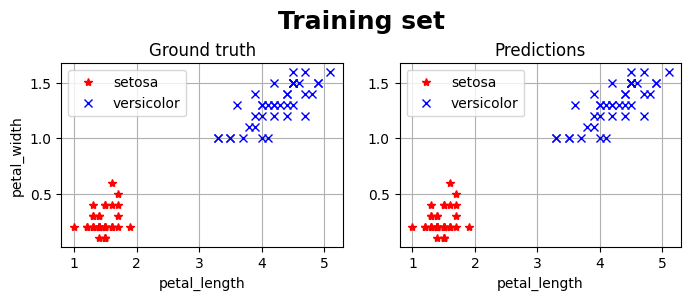

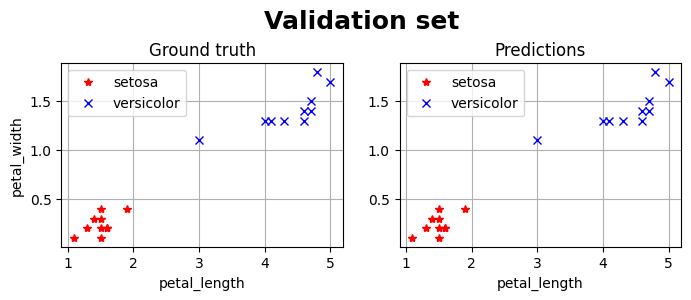

In [9]:
show_predictions(features_train, y_train, train_predprob,
                 class_names, column_names, 'Training set')
save_fig("iris_predictions_train.pdf", tight_layout=False)

show_predictions(features_val, y_val, val_predprob,
                 class_names, column_names, 'Validation set')

save_fig("iris_predictions_val.pdf", tight_layout=False)

In [10]:
def show_predicted_probabilities(axes, y_true, y_pred, class_names, title):
    for i,color in zip(range(2),['r*','bx']):
        rows = y_true[:,i] == 1
        ind = torch.where(y_true[:,i] == 1)[0]
        axes.plot(ind, torch.tensor(y_pred[rows,i]), color, label=class_names[i])
    axes.plot([0, y_true.shape[0]], [0.5, 0.5], 'k--')
    axes.set_ylim([0,1])
    axes.set_xlabel('data instance')
    axes.set_ylabel('predicted probability')
    axes.grid('on')
    axes.legend(loc='best')
    axes.set_title(title)

/tmp/ipykernel_3037138/2071024213.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes.plot(ind, torch.tensor(y_pred[rows,i]), color, label=class_names[i])


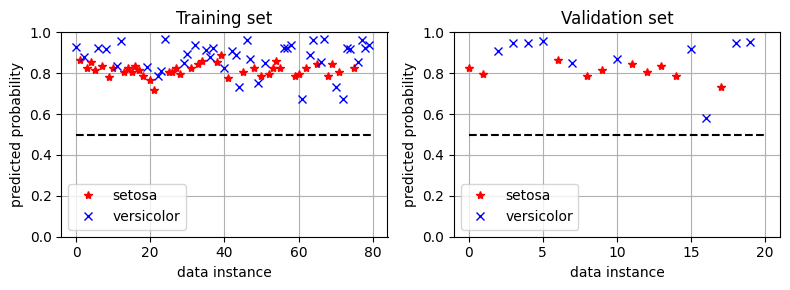

In [11]:
_, axes = plt.subplots(1, 2, figsize=(8,3))
show_predicted_probabilities(axes[0], y_train, train_predprob,
                             class_names, 'Training set')
show_predicted_probabilities(axes[1], y_val, val_predprob,
                             class_names, 'Validation set')
save_fig("iris_predprobs.pdf")

Ideally, we would want the probabilities of predictions to be very close to 1. For this dataset, the mean probabilities of predictions for the training and validation set are around 0.85. This is very good. However, for some complex datasets, we tend to see probabilities very close to 0.5.